In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
traps = pd.read_csv('assets/train.csv')
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')

In [3]:
# pip install pandas-profiling
import pandas_profiling as pdp

pdp.ProfileReport(traps) #  offers out-of-the-box statistical profiling of your dataset

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Number of variables,12
Number of observations,10506
Total Missing (%),0.0%
Total size in memory,985.0 KiB
Average record size in memory,96.0 B
Numeric,6
Categorical,6
Date,0
Text (Unique),0
Rejected,0
Distinct count,138


In [2]:
### Modify trap dataset

# Convert Date column to actual date data type
traps.Date = pd.to_datetime(traps.Date)

# Create dummies for Species and Trap
dummies = pd.get_dummies(traps, columns=['Species'])

# Create a new df with the dummies
traps_2_cols = traps.columns.drop('Species')
traps_2 = pd.concat([traps[traps_2_cols],dummies])
traps_2.head()

,Address,AddressAccuracy,AddressNumberAndStreet,Block,Date,Latitude,Longitude,NumMosquitos,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Street,Trap,WnvPresent
0,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,41.954690,-87.800991,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N OAK PARK AVE,T002,0
1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9,"4100 N OAK PARK AVE, Chicago, IL",41,2007-05-29,41.954690,-87.800991,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N OAK PARK AVE,T002,0
2,"6200 North Mandell Avenue, Chicago, IL 60646, USA",9,"6200 N MANDELL AVE, Chicago, IL",62,2007-05-29,41.994991,-87.769279,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N MANDELL AVE,T007,0
3,"7900 West Foster Avenue, Chicago, IL 60656, USA",8,"7900 W FOSTER AVE, Chicago, IL",79,2007-05-29,41.974089,-87.824812,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W FOSTER AVE,T015,0
4,"7900 West Foster Avenue, Chicago, IL 60656, USA",8,"7900 W FOSTER AVE, Chicago, IL",79,2007-05-29,41.974089,-87.824812,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W FOSTER AVE,T015,0


In [5]:
pdp.ProfileReport(spray)

Number of variables,4
Number of observations,14835
Total Missing (%),1.0%
Total size in memory,463.7 KiB
Average record size in memory,32.0 B
Numeric,2
Categorical,2
Date,0
Text (Unique),0
Rejected,0
Distinct count,10


In [3]:
import datetime
# Convert Date column to actual date data type
spray.Date = pd.to_datetime(spray.Date)

In [7]:
pdp.ProfileReport(weather)

Number of variables,22
Number of observations,2944
Total Missing (%),0.0%
Total size in memory,506.1 KiB
Average record size in memory,176.0 B
Numeric,5
Categorical,15
Date,0
Text (Unique),0
Rejected,2
Distinct count,178


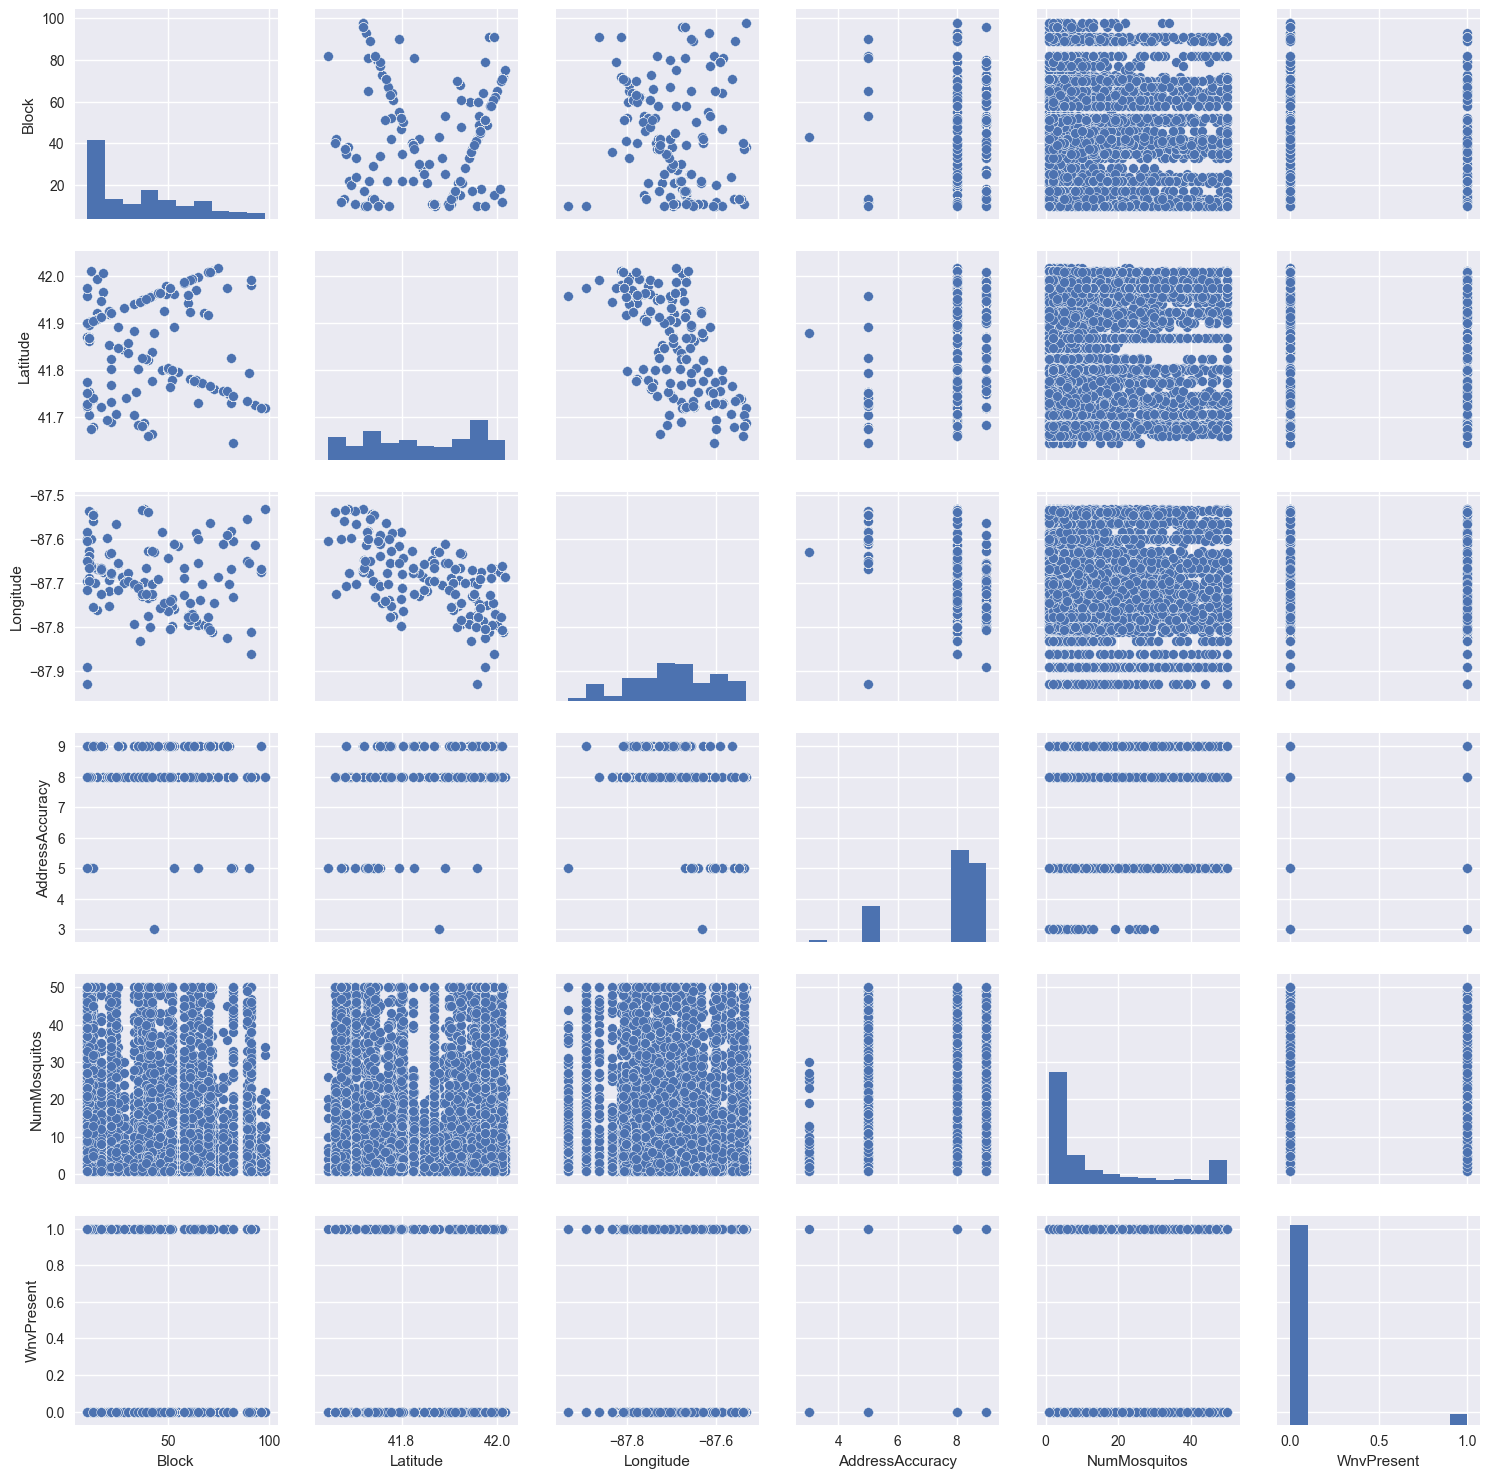

In [8]:
import seaborn as sns
sns.pairplot(traps)

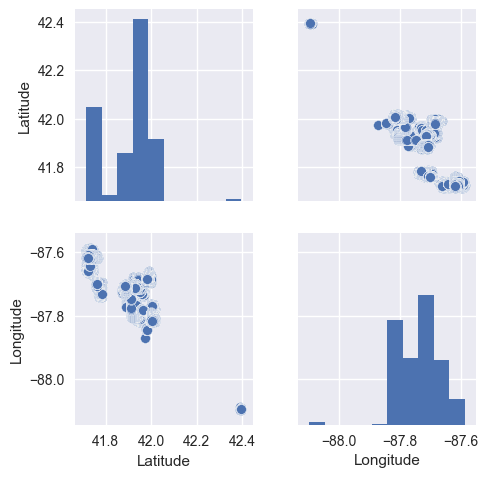

In [9]:
sns.pairplot(spray)

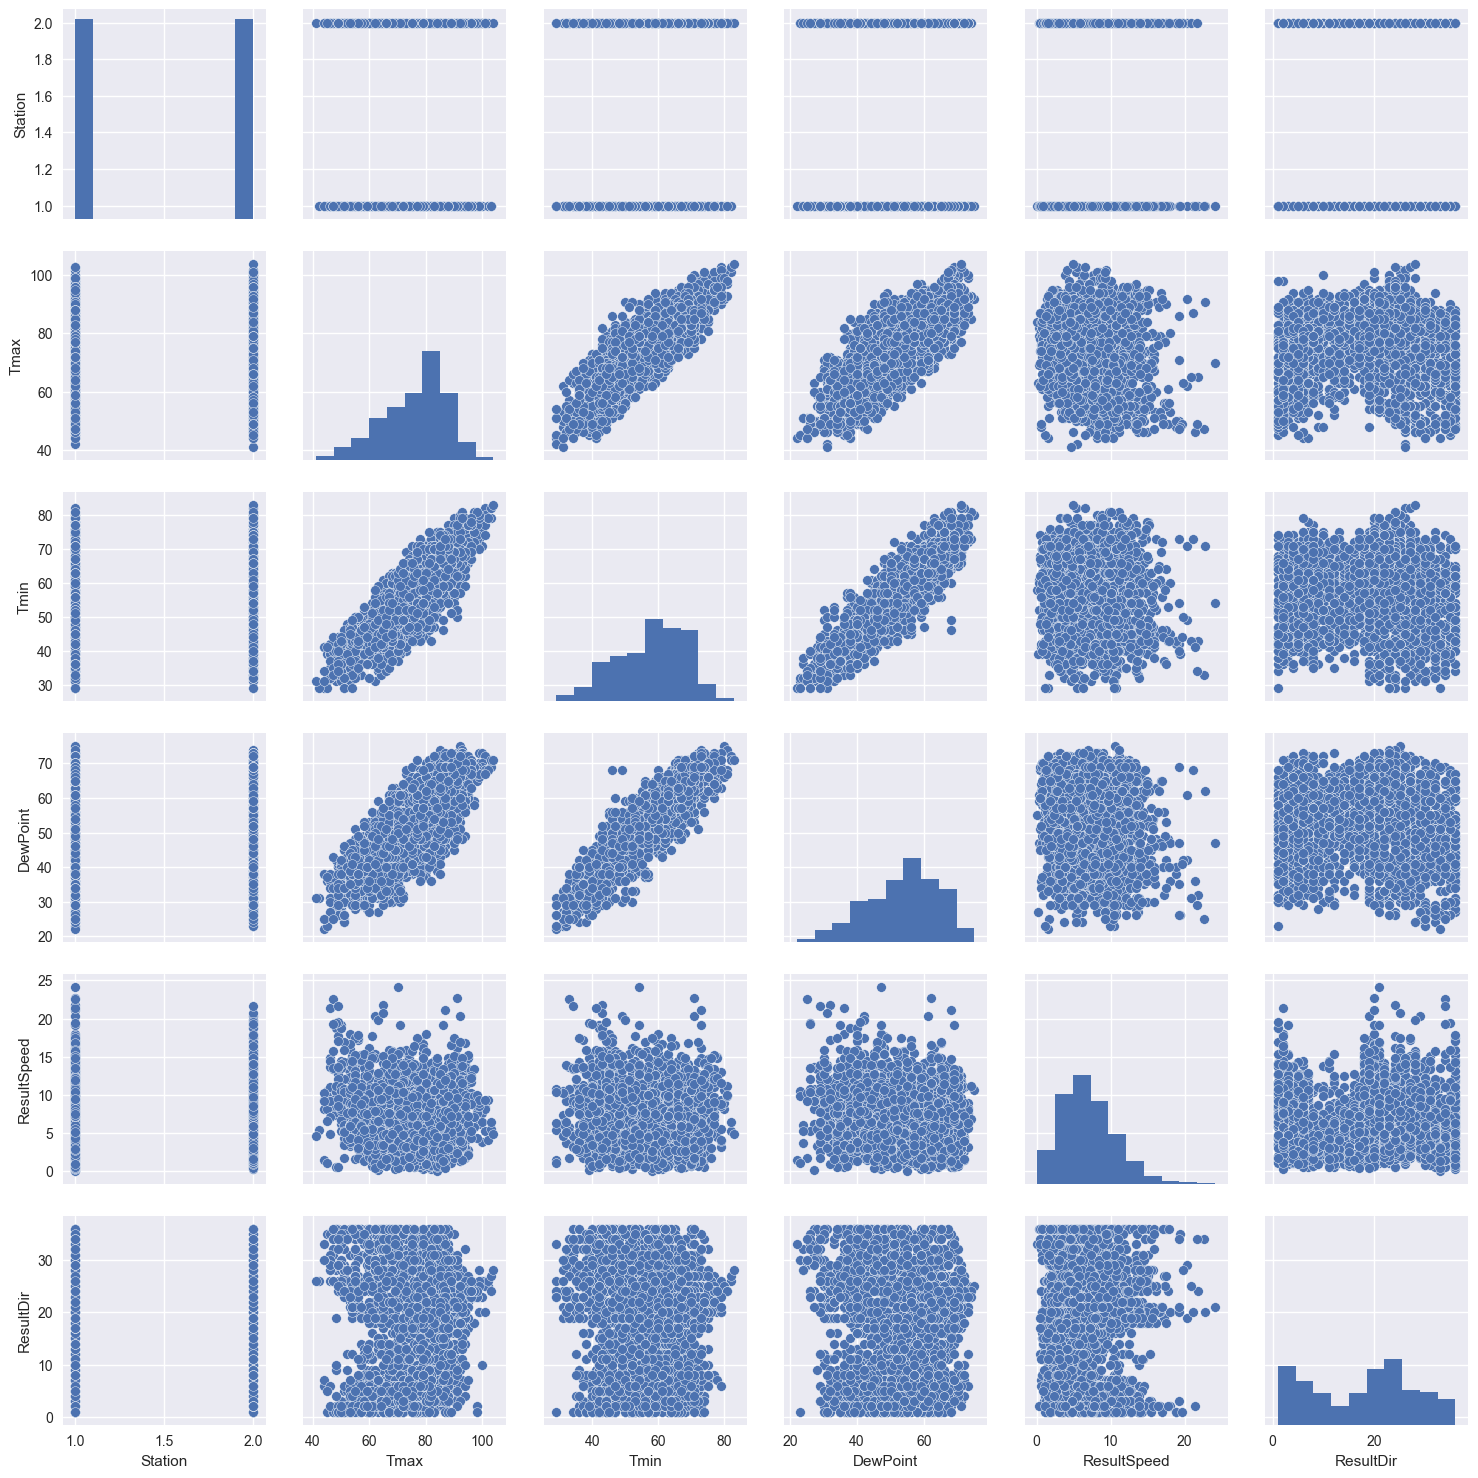

In [10]:
sns.pairplot(weather)

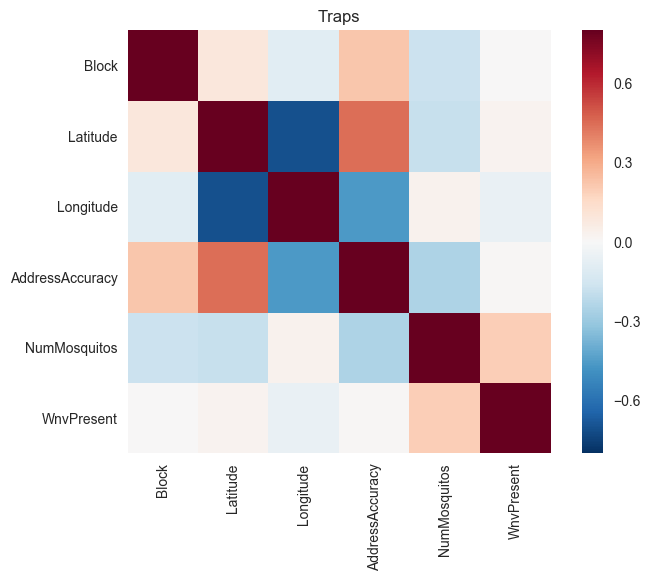

In [11]:
def find_correlation(data,title):
    correlation = data.corr()
    sns.heatmap(correlation, vmax=.8, square=True)
    plt.title(title)

find_correlation(traps, 'Traps')

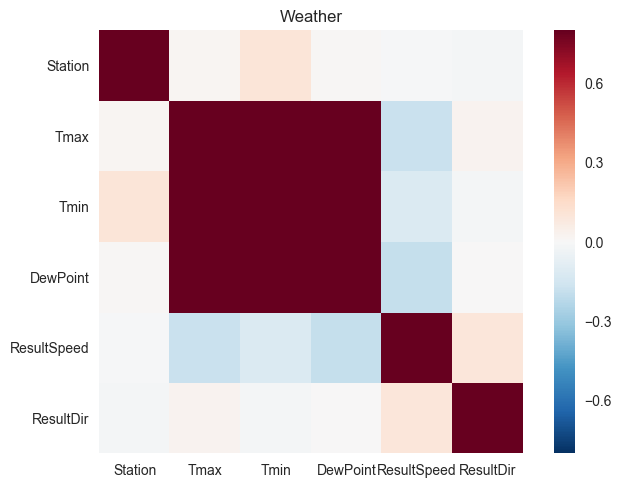

In [12]:
find_correlation(weather, 'Weather')

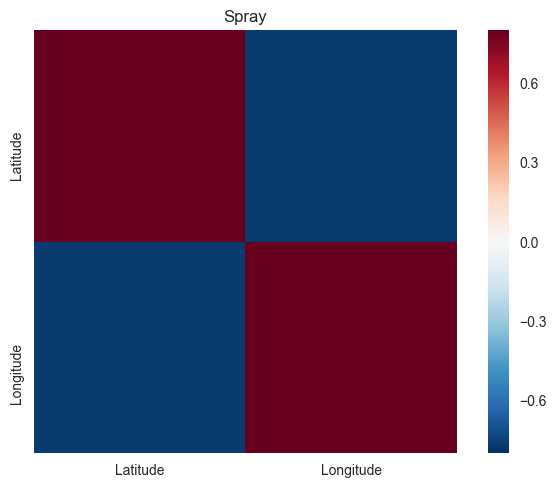

In [13]:
find_correlation(spray, 'Spray')

In [10]:
# ,'-88.089163'
traps[traps.Latitude==42.391623]

from geopy.distance import vincenty

traps['spray'] = 'N'
for i in range(0,len(traps)+1):
    trap_lat = traps.Latitude[i] 
    trap_long = traps.Longitude[i]
    spray_lat = traps.Latitude[i] 
    spray_long = traps.Longitude[i]
    a = (trap_lat, trap_long)
    b = (spray_lat, spray_long)
    if vincenty(a, b).miles < 0.25:
        traps.spray[i] = 'Y'


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 10506

In [9]:
traps.Latitude[5] 

41.921599999999998

In [7]:
traps.Latitude

0        41.954690
1        41.954690
2        41.994991
3        41.974089
4        41.974089
5        41.921600
6        41.891118
7        41.867108
8        41.867108
9        41.896282
10       41.919343
11       41.921965
12       41.921965
13       41.688324
14       41.688324
15       41.862292
16       41.720848
17       41.731922
18       41.731922
19       41.891126
20       41.891126
21       41.999129
22       42.017430
23       41.907645
24       41.732984
25       41.954690
26       41.954690
27       41.954690
28       41.974089
29       41.974089
           ...    
10476    41.750498
10477    41.750498
10478    41.750498
10479    41.984809
10480    41.659112
10481    41.659112
10482    41.659112
10483    41.992478
10484    41.974689
10485    41.974689
10486    41.974689
10487    41.974689
10488    41.974689
10489    41.974689
10490    41.925198
10491    41.973845
10492    41.973845
10493    41.743402
10494    41.728495
10495    41.728495
10496    41.947227
10497    41.